In [97]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import mean_squared_error
from collections import Counter
import math
import optuna
import matplotlib.pyplot as plt

In [98]:
df = pd.read_csv("data.csv")

In [99]:
print(df.head())

   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY


In [100]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Sex'] = pd.factorize(df['Sex'])[0]
df['BP'] = pd.factorize(df['BP'])[0]
df['Cholesterol'] = pd.factorize(df['Cholesterol'])[0]
df['Na_to_K'] = pd.factorize(df['Na_to_K'])[0]
df['Drug'] = pd.factorize(df['Drug'])[0]

In [101]:
scaler = MinMaxScaler()
columns_to_normalize = df.columns[df.columns != 'Drug']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [102]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,0.135593,0.0,0.0,0.0,0.000000,0
1,0.542373,1.0,0.5,0.0,0.005076,1
2,0.542373,1.0,0.5,0.0,0.010152,1
3,0.220339,0.0,1.0,0.0,0.015228,2
4,0.779661,0.0,0.5,0.0,0.020305,0


In [103]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
y = df['Drug']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4)

In [105]:
print(X_train[:10])

          Age  Sex   BP  Cholesterol   Na_to_K
93   0.457627  0.0  0.5          1.0  0.472081
124  0.644068  0.0  0.0          1.0  0.629442
167  0.711864  0.0  1.0          0.0  0.842640
83   0.389831  0.0  0.0          1.0  0.421320
138  0.610169  1.0  0.0          1.0  0.700508
171  0.508475  1.0  0.5          1.0  0.862944
60   0.389831  0.0  0.5          1.0  0.304569
132  0.576271  1.0  0.5          1.0  0.670051
197  0.627119  1.0  1.0          0.0  0.989848
172  0.406780  0.0  1.0          1.0  0.868020


## Sklearn

In [106]:
optuna.logging.disable_default_handler()

In [107]:
def neighbors_and_p_params(trial):
    n = trial.suggest_int('n_neighbors', 3, 10)
    p = trial.suggest_int('p', 1, 10)
    knn = KNeighborsClassifier(n_neighbors=n, p=p)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

def neighbors_param(trial):
    n = trial.suggest_int('n_neighbors', low=1, high=10, step=1)
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

def p_param(trial):
    p = trial.suggest_int('p', 1, 10)
    knn = KNeighborsClassifier(p=p)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

def print_best(tr):
    print("Best params:")
    for key, value in tr.params.items():
        print(key, '=', value)
    print('Best accuracy=', tr.value)


## Кол-во соседей и расстояние

In [108]:
study = optuna.create_study(direction='maximize')

study.optimize(neighbors_and_p_params, n_trials=100)

tr = study.best_trial
print_best(tr)


Best params:
n_neighbors = 8
p = 1
Best accuracy= 0.45


## Количество соседей

Best params:
n_neighbors = 6
Best accuracy= 0.45


Text(0, 0.5, 'accuracy')

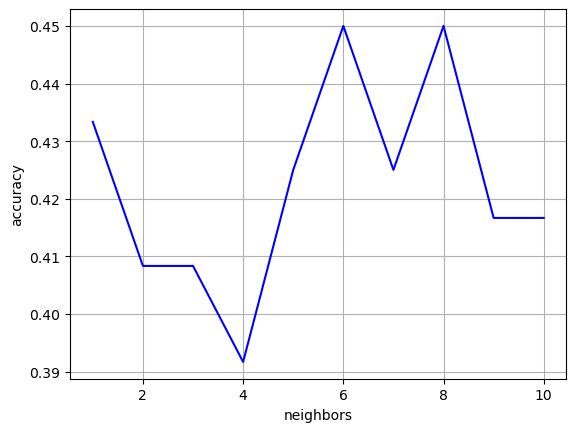

In [109]:
study = optuna.create_study(direction='maximize')
study.optimize(neighbors_param, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['n_neighbors'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]

mp = dict()

for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('neighbors')
plt.ylabel('accuracy')

## Расстояние

Best params:
p = 3
Best accuracy= 0.44166666666666665


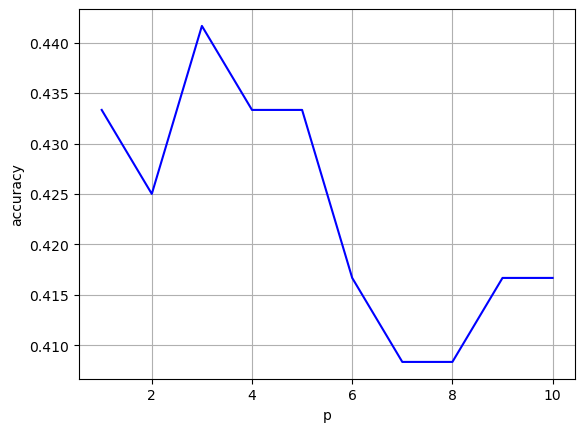

In [110]:
study = optuna.create_study(direction='maximize')
study.optimize(p_param, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['p'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]


mp = dict()

mp = dict()

for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('p')
plt.ylabel('accuracy')
plt.show()

## My knn

## Metrics

In [111]:
def minkowski(a, b, p):
    sm = 0
    for i in range(len(a)):
        sm = sm + (abs(a[i] - b[i]) ** p)
    return sm ** p

def cos_similarity(a, b):
    pr = np.dot(a, b)
    a1 = np.linalg.norm(a)
    b1 = np.linalg.norm(b)
    return pr / a1 * b1


In [112]:
def manhattan(a, b):
    return minkowski(a, b, 1)

def evk(a, b):
    return minkowski(a, b, 2)

def cos_dist(a, b):
    return 1 - cos_similarity(a, b)

metrics = [manhattan, evk, cos_dist]

# Kernels

In [113]:
def uniform(u):
    t = 1 if u < 1 else 0
    return t * 0.5

def epan(u):
    t = 1 if u < 1 else 0
    return 3 / 4 * (1 - u**2) * t

def triang(u):
    t = 1 if u < 1 else 0
    return (1 - abs(u)) * t

def gaussian(u):
    return 1 / math.sqrt(2 * 3.14) * math.exp(-(u**2) / 2)

kernels = [uniform, epan, triang, gaussian]

In [114]:
arr = []
X = []
y = []
for _, row in df.iterrows():
    val = []
    for _, v in row.items():
            val.append(v)
    X.append(val[:-1])
    y.append(val[-1])
    arr.append((val[:-1], val[-1]))

## Train and test

In [115]:
p = int(len(arr) * 0.4)
train = arr[:p]
test = arr[p:]
for i in range(10):
    print(train[i])

([0.13559322033898308, 0.0, 0.0, 0.0, 0.0], 0.0)
([0.5423728813559322, 1.0, 0.5, 0.0, 0.005076142131979695], 1.0)
([0.5423728813559322, 1.0, 0.5, 0.0, 0.01015228426395939], 1.0)
([0.22033898305084748, 0.0, 1.0, 0.0, 0.015228426395939085], 2.0)
([0.7796610169491525, 0.0, 0.5, 0.0, 0.02030456852791878], 0.0)
([0.11864406779661019, 0.0, 1.0, 0.0, 0.025380710659898477], 2.0)
([0.576271186440678, 0.0, 1.0, 0.0, 0.03045685279187817], 0.0)
([0.44067796610169496, 1.0, 0.5, 0.0, 0.035532994923857864], 1.0)
([0.7627118644067796, 1.0, 1.0, 0.0, 0.04060913705583756], 0.0)
([0.47457627118644063, 1.0, 0.5, 1.0, 0.04568527918781726], 0.0)


In [116]:
def const_window(cur, data, kernel, metric, h, k, w=None):
    dst = []
    for i in range(len(data)):
        el = data[i]
        x = 1 if w == None else w[i]
        t = x * kernel(metric(cur, el[0]) / h)
        dst.append((el[1], t))
    s = sorted(dst, key=lambda x: x[1])
    f = [pair[0] for pair in s]
    c = Counter(f[:k])
    return c.most_common(1)[0][0]

def window(cur, data, kernel, metric, k, w=None):
    dst = []
    for i in range(len(data)):
        el = data[i]
        t = metric(cur, el[0])
        dst.append((el[1], t))
    s = sorted(dst, key=lambda x: x[1])
    h = s[k+1][1]
    return const_window(cur, data, kernel, metric, h * 2, k, w)


In [117]:
#def predict(h, n, kernel, metric, w=None):
#    res = []
#    for i in range(len(test)):
#        cur = test[i]
#        res.append(const_window(cur[0], train, kernel, metric, h, n, w))
#    return res

def predict(n, kernel, metric, h=None, w=None):
    res = []
    for i in range(len(test)):
        cur = test[i]
        if h == None:
            res.append(window(cur[0], train, kernel, metric, n, w))
        else:
            res.append(const_window(cur[0], train, kernel, metric, h, n, w))
    return res

In [118]:
exp = [p[1] for p in test]

In [119]:
def all_params(trial):
    n = trial.suggest_int('neighbors', 3, 10)
    h = trial.suggest_int('h', 1, 100)
    res = predict(h=h, n=n, kernel=triang, metric=evk)
    return accuracy_score(res, exp)

def my_h(trial):
    h = trial.suggest_int('h', 1, 100)
    res = predict(h=h, n=10, kernel=triang, metric=evk)
    return accuracy_score(res, exp)

def my_n(trial):
    n = trial.suggest_int('neighbors', 3, 10)
    res = predict(h=10, n=n, kernel=triang, metric=evk)
    return accuracy_score(res, exp)


## Соседи и расстояние

In [120]:
study = optuna.create_study(direction='maximize')
study.optimize(all_params, n_trials=100)

tr = study.best_trial
print_best(tr)

Best params:
neighbors = 9
h = 1
Best accuracy= 0.43333333333333335


## Расстояние

Best params:
h = 1
Best accuracy= 0.425


Text(0, 0.5, 'accuracy')

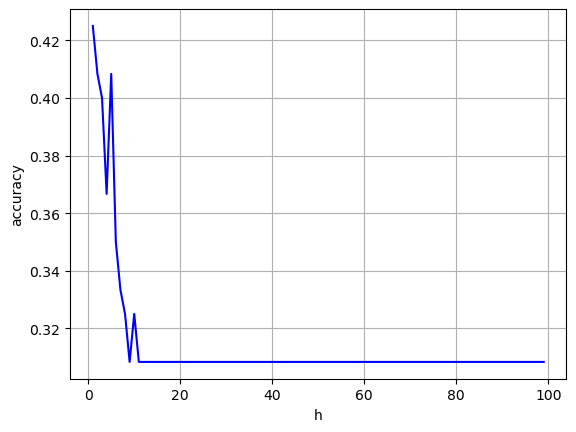

In [121]:
study = optuna.create_study(direction='maximize')
study.optimize(my_h, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['h'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]

mp = dict()
for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('h')
plt.ylabel('accuracy')



## Соседи

Best params:
neighbors = 10
Best accuracy= 0.325


Text(0, 0.5, 'accuracy')

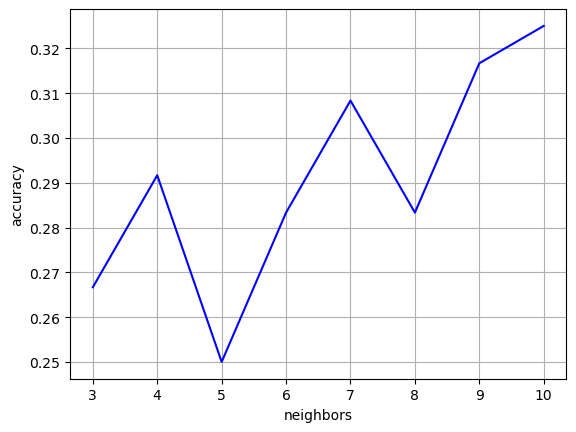

In [122]:
study = optuna.create_study(direction='maximize')
study.optimize(my_n, n_trials=100)
tr = study.best_trial
print_best(tr)

x_values = [trial.params['neighbors'] for trial in study.get_trials()]
y_values = [trial.value for trial in study.get_trials()]

mp = dict()
for i in range(len(x_values)):
    key = x_values[i]
    value = y_values[i]
    if key not in mp:
        mp[key] = value
    else:
        mp[key] = max(mp[key], value)

sorted_dict = dict(sorted(mp.items()))
x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plt.plot(x, y, color='blue')
plt.grid(True)
plt.xlabel('neighbors')

plt.ylabel('accuracy')

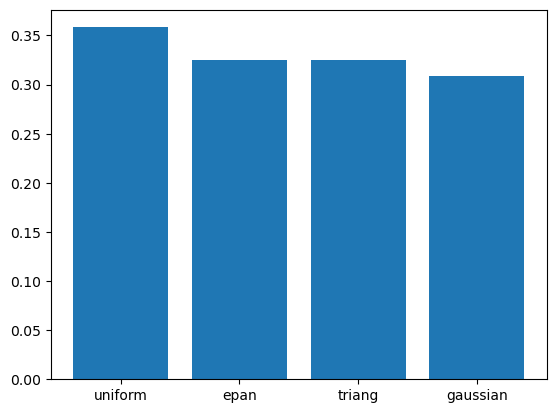

In [123]:
mp = dict()
for kernel in kernels:
    res = predict(h=10, n=10, kernel=kernel, metric=evk)
    acc = accuracy_score(res, exp)
    mp[kernel.__name__] = acc

x_values = list(mp.keys())    
y_values = list(mp.values())

plt.bar(x_values, y_values)
plt.show()


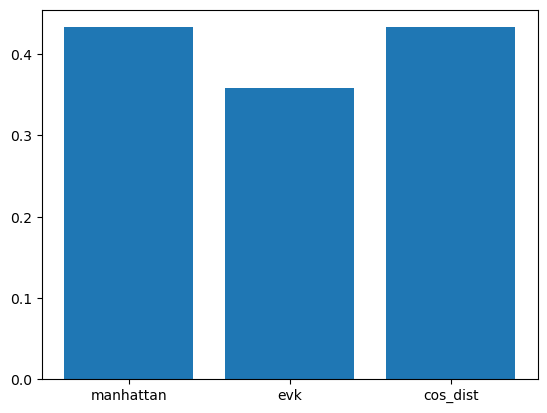

In [124]:
mp = dict()
for metr in metrics:
   res = predict(h=10, n=10, kernel=uniform, metric=metr) 
   acc = accuracy_score(res, exp)
   mp[metr.__name__] = acc

x_values = list(mp.keys())
y_values = list(mp.values())
plt.bar(x_values, y_values)
plt.show()

In [125]:
def lowess(train, frac, iters):
    hlp = [el[0] for el in train]
    y = np.array([el[1] for el in train])
    
    matrix = np.array(hlp)    
    res = [0]*len(hlp)
    
    for _ in range(iters):
        for i in range(len(hlp)):
            #d = np.sqrt((x1 - x1[i])**2 + (x2 - x2[i])**2 + (x3 - x3[i])**2 + (x4 - x4[i])**2 + (x5 - x5[i])**2)
            tmp = 0
            for c in matrix.T:
                tmp += (c - c[i])**2
            d = np.sqrt(tmp)
            weights = np.exp(-0.5 * (d / frac) ** 2)
            weights /= sum(weights)

            res[i] = sum(weights * y)

    return res
    
    

In [126]:
knn = KNeighborsClassifier(n_neighbors=3, p=8, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
res1 = accuracy_score(y_test, y_pred)
print('Result=',res1)

Result= 0.425


In [127]:
w = lowess(train, 0.4, 10)
y_pred = predict(h=1, n=9, kernel=triang, metric=manhattan, w=w)
res = accuracy_score(y_test, y_pred)
print('Result=', res)

Result= 0.475
